In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception, InceptionResNetV2, MobileNetV2
from keras import Model 
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


**Importing Pre_trained Model to apply Transfer Learning**

In [ ]:
# base_model = Xception(weights='imagenet', include_top = False, input_shape = (150, 150, 3))
# base_model = InceptionResNetV2(weights='imagenet', include_top = False, input_shape = (150, 150, 3))
# base_model = MobileNetV2(weights='imagenet', include_top = False, input_shape = (150, 150, 3))

## Creating Training Data
**Set Up the Scenes Dataset**

In [ ]:
# Training Set Directory
dir = '/content/gdrive/MyDrive/dataset/train-scene classification/train'
dataset = pd.read_csv("/content/gdrive/MyDrive/dataset/train-scene classification/train.csv")    # Dataframe
dataset["label"] = dataset["label"].astype(str) # Converting Class number to strings

## Splitting Data into Train/Test

In [ ]:
data_train, data_test = train_test_split(dataset, test_size=0.2)                   # Splitting in 80:20

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 150
size = (IMG_SIZE, IMG_SIZE)

## Creating Keras Image Data Flow


In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)


valid_generator = valid_datagen.flow_from_dataframe(dataframe = data_test,           # Training Dataframe
                                      directory = dir,                   # Training set Directory
                                      batch_size = BATCH_SIZE,                    # Size of Batch
                                      class_mode = "categorical",         # Type of Labels
                                      x_col = "image_name",               # Input Column
                                      color_mode = "rgb",                 # Image Format
                                      y_col = "label",                    # Target Column
                                      target_size = size)            # Image Size

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen


train_generator = train_datagen.flow_from_dataframe(dataframe = data_train,           # Training Dataframe
                                      directory = dir,                   # Training set Directory
                                      batch_size = BATCH_SIZE,                    # Size of Batch
                                      class_mode = "categorical",         # Type of Labels
                                      x_col = "image_name",               # Input Column
                                      color_mode = "rgb",                 # Image Format
                                      y_col = "label",                    # Target Column
                                      target_size = size)            # Image Size




Found 3407 validated image filenames belonging to 6 classes.
Found 13627 validated image filenames belonging to 6 classes.


## Building Model

In [ ]:
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.3)(x)
# x = Dense(units=128, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(units=256, activation='relu')(x)
# x = Dropout(0.3)(x)
output = Dense(units=6, activation='softmax')(x)
model = Model(base_model.input, output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

### Setting Loss function, Optimizer and Compling the model

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

### Compiling the Model

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
initial_epochs = 10

425
106


In [ ]:
transfer_learning_history = model.fit(
    train_generator,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps)

Epoch 1/10
425/425 [==============================] - 111s 247ms/step - loss: 0.7133 - accuracy: 0.7362 - val_loss: 0.3164 - val_accuracy: 0.8818
Epoch 2/10
425/425 [==============================] - 104s 244ms/step - loss: 0.4536 - accuracy: 0.8394 - val_loss: 0.2856 - val_accuracy: 0.8936
Epoch 3/10
425/425 [==============================] - 103s 243ms/step - loss: 0.4478 - accuracy: 0.8357 - val_loss: 0.2943 - val_accuracy: 0.8862
Epoch 4/10
425/425 [==============================] - 103s 243ms/step - loss: 0.4088 - accuracy: 0.8562 - val_loss: 0.2760 - val_accuracy: 0.8977
Epoch 5/10
425/425 [==============================] - 104s 244ms/step - loss: 0.3936 - accuracy: 0.8565 - val_loss: 0.2903 - val_accuracy: 0.8933
Epoch 6/10
425/425 [==============================] - 103s 242ms/step - loss: 0.3850 - accuracy: 0.8574 - val_loss: 0.2727 - val_accuracy: 0.8962
Epoch 7/10
425/425 [==============================] - 103s 242ms/step - loss: 0.3764 - accuracy: 0.8625 - val_loss: 0.2843 -

## Visualizing accuracy and loss

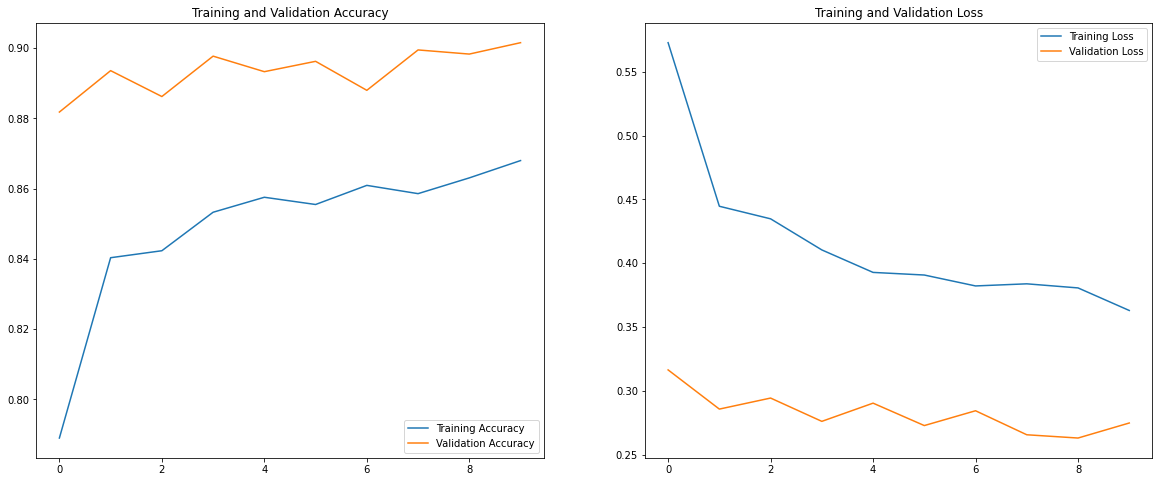

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy'][:10]
val_acc = transfer_learning_history.history['val_accuracy'][:10]

loss = transfer_learning_history.history['loss'][:10]
val_loss = transfer_learning_history.history['val_loss'][:10]

epochs_range = range(10)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

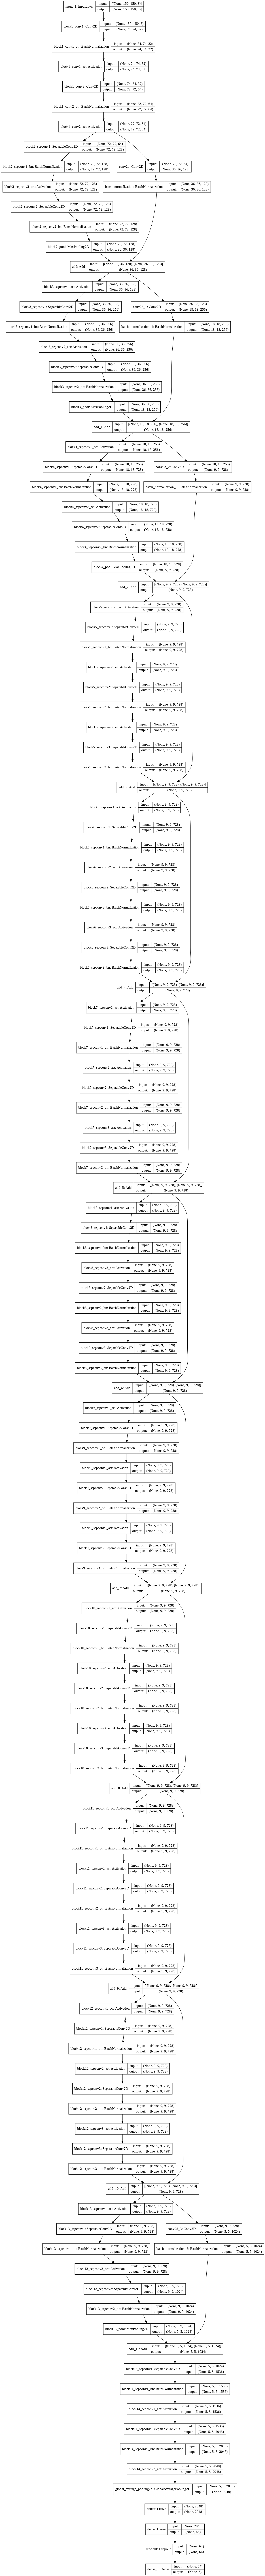

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
for layer in model.layers[:]:
    layer.trainable = False
for layer in model.layers[-21:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

In [ ]:

for i,layer in enumerate(model.layers):
    print(i,layer.name,layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
fine_tuning_history = model.fit(
    train_generator,
    epochs = total_epochs,
    initial_epoch = transfer_learning_history.epoch[-1],
    steps_per_epoch = steps_per_epoch,
    validation_data = valid_generator,
    validation_steps = validation_steps)
    

Epoch 10/20
425/425 [==============================] - 109s 250ms/step - loss: 0.3765 - accuracy: 0.8610 - val_loss: 0.2219 - val_accuracy: 0.9207
Epoch 11/20
425/425 [==============================] - 105s 246ms/step - loss: 0.3113 - accuracy: 0.8896 - val_loss: 0.2123 - val_accuracy: 0.9210
Epoch 12/20
425/425 [==============================] - 105s 246ms/step - loss: 0.2823 - accuracy: 0.8944 - val_loss: 0.2105 - val_accuracy: 0.9257
Epoch 13/20
425/425 [==============================] - 105s 247ms/step - loss: 0.2485 - accuracy: 0.9105 - val_loss: 0.1988 - val_accuracy: 0.9284
Epoch 14/20
425/425 [==============================] - 105s 247ms/step - loss: 0.2400 - accuracy: 0.9153 - val_loss: 0.2022 - val_accuracy: 0.9251
Epoch 15/20
425/425 [==============================] - 105s 248ms/step - loss: 0.2202 - accuracy: 0.9233 - val_loss: 0.1955 - val_accuracy: 0.9313
Epoch 16/20
425/425 [==============================] - 106s 249ms/step - loss: 0.2137 - accuracy: 0.9224 - val_loss: 0

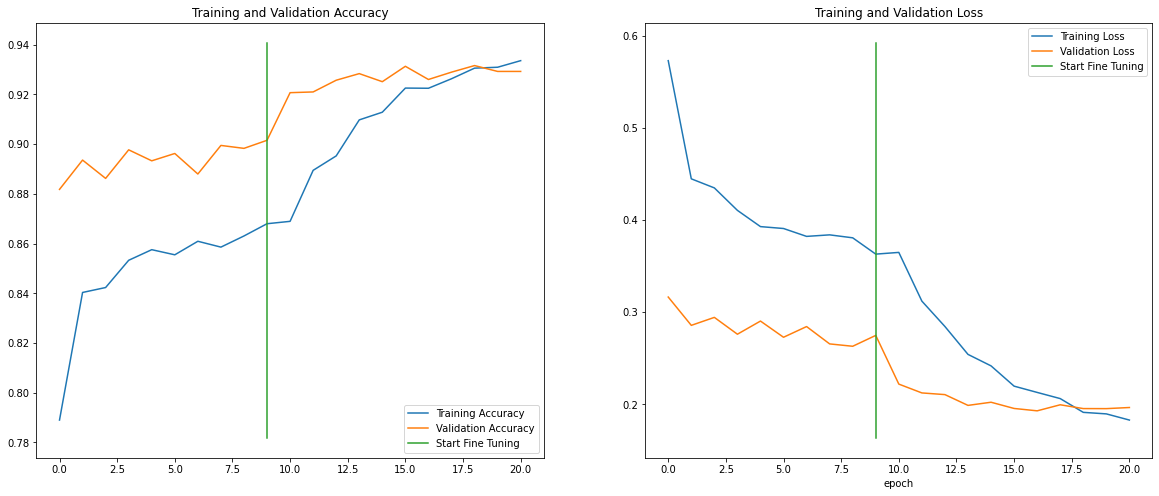

In [ ]:
acc += fine_tuning_history.history['accuracy']
val_acc += fine_tuning_history.history['val_accuracy']

loss += fine_tuning_history.history['loss']
val_loss += fine_tuning_history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()